In [ ]:
import pandas as pd
import numpy as np
import os
import math
import sklearn 
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf


In [ ]:
train = pd.read_csv(r'C:\Users\Admin\PetAdoption\train\train.csv')
breed = pd.read_csv(r'C:\Users\Admin\PetAdoption\PetFinder-BreedLabels.csv')
color = pd.read_csv(r'C:\Users\Admin\PetAdoption\PetFinder-ColorLabels.csv')
state = pd.read_csv(r'C:\Users\Admin\PetAdoption\PetFinder-StateLabels.csv')
test = pd.read_csv(r'C:\Users\Admin\PetAdoption\test\test.csv')

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or ignore specific warnings by category (e.g., FutureWarnings)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Predicting using categorical and numerical data

## 2.1 Data preparation

In [ ]:
########  DEFINING A FUNCTION THAT PREPARE CORRECT INPUT FOR MODEL #########
def get_input(df, breed,color,state):
    # Merging with other tables to get labels
    df_drop = df.drop(['PhotoAmt','PetID','Description','VideoAmt','RescuerID','Name'],axis=1)
    df_drop = df_drop.rename(columns={'Breed1':'BreedID'}).merge(breed, on=['BreedID','Type'],how='left').drop('BreedID',axis=1)
    df_drop = df_drop.rename(columns={'Breed2':'BreedID'}).merge(breed, on=['BreedID','Type'],how='left').drop('BreedID',axis=1)
    
    for color_col in ['Color1','Color2','Color3']:
        df_drop = df_drop.rename(columns={color_col: 'ColorID'}).merge(color, on ='ColorID', how = 'left').drop('ColorID',axis=1)
    df_drop = df_drop.rename(columns={'State':'StateID'}).merge(state,on ='StateID', how = 'left').drop('StateID',axis=1)

    # Get label of data to understand the context
    label_dict = {
        'Type': ['Not specified','Dog','Cat'],
        'Gender': ['Not specified','Male','Female','Mixed'],
        'FurLength': ['Not specified','Short','Medium','Long'],
        'Vaccinated': ['Not specified','Yes','No'],
        'Dewormed': ['Not specified','Yes','No'],
        'Sterilized': ['Not specified','Yes','No'],
        'Health': ['Not specified','Healthy','Minor Injury','Serious Injury'],
        'MaturitySize': ['Not specified','Small','Medium','Large','Extra Large'],
        'AdoptionSpeed': ['First_day', 'First_week', 'First_month', 'First_30_to_90_days', 'First_100_days']
    }

    for col in df_drop.columns:
        if col in label_dict:
            label_list = label_dict[col]
            for number in range(len(label_list)):
                df_drop[col][df_drop[col] == number] = label_list[number]
    df_labeled = df_drop
    df_dummy = pd.get_dummies(df_labeled,dtype=int)
    
    return df_dummy, df_labeled

In [ ]:
data_train_eval = get_input(train,breed,color,state)[0] # take df_dum
data_test = get_input(test,breed,color,state)[0] # take df_dum
# Split train data to train - evaluate set:
n_split = math.floor(data_train_eval.shape[0] * 0.8)
data_train = data_train_eval.sample(n=len(data_train_eval),random_state=31,ignore_index=True) # shuffle data

data_train = data_train_eval.iloc[:n_split,:]
data_eval = data_train_eval.iloc[n_split:,:]

## 2.2 Predicting with XGBoost 

In [ ]:
def training_multiple_models(data_train, data_eval):
    # function that return 5 inputs (used to train on 5 outcome of the model):
    def get_5_input(data):
        data_dict = {}
        y_list = ['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']
        for y_target in y_list:
            xdata = data.drop(y_list,axis=1)
            ydata = data[y_target]
            data_dict[y_target] = (xdata,ydata)
        return data_dict
    # use get_5_input fuction to get data dict for train and eval data:
    data_train_dict = get_5_input(data_train)
    data_eval_dict = get_5_input(data_eval)

    # function that build, train 5 models: 
    def build_train_model(data_train_dict, data_eval_dict):
        model_dict = {}
        for target_data in data_train_dict.keys():
            xtrain = data_train_dict[target_data][0]
            ytrain = data_train_dict[target_data][1]
            eval_set = data_eval_dict[target_data]
            model = XGBClassifier()
            model.fit(
                xtrain, ytrain,
                eval_set= [eval_set], 
                verbose = False
            )
            model_dict[target_data] = model
        return model_dict
    
    # use build_train_model function to generate 5 models that predict 5 outcomes:
    model_dict = build_train_model(data_train_dict, data_eval_dict)

    return model_dict

In [ ]:
# Get list of full columns
full_columns_ordered = data_train.drop(
        ['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']
        , axis =1
        ).columns

In [ ]:
# function that prepare input data and predict:
def prepare_predict(data, full_columns_ordered, model_dict):
    # function that padding and re-ordering data's column to fit with columns used to train:
    def input_columns_adjustment(data, full_columns_ordered):
        # padding missing columns to current data
        columns_that_appear_both = full_columns_ordered.isin(data.columns)
        columns_that_are_missing_and_undefined = full_columns_ordered[columns_that_appear_both == 0]
        df_with_missing_and_undefined_columns = pd.DataFrame(np.zeros((len(data),len(columns_that_are_missing_and_undefined))),
                                                                columns = columns_that_are_missing_and_undefined)
        if df_with_missing_and_undefined_columns.empty == True: return data[full_columns_ordered] # this line to fix the logical error of this function
        else:
            data = pd.concat([
                data, df_with_missing_and_undefined_columns
            ], axis=1)
            # excluding cols that are not predefined and reordering data to match training data
            data = data[full_columns_ordered]
        return data
    
    # use input_columns_adjustment to preapre input data:
    data_prepared = input_columns_adjustment(data, full_columns_ordered)

    
    # Predicting and generate df result
    ## initiate df
    y_pred_df_5 = pd.DataFrame(np.zeros((len(data_prepared),1)))
    ## predict multiple times:
    for model_y in model_dict.values():
        y_pred = model_y.predict_proba(data_prepared)
        y_pred_true = y_pred[:,1:]
        y_pred_true = pd.DataFrame(y_pred_true)
        y_pred_df_5 = pd.concat([y_pred_df_5,y_pred_true],axis = 1)
    y_pred_df_5 = y_pred_df_5.iloc[:,1:]
    y_pred_df_5.columns = model_dict.keys()


    # get the column that has the highest percentage for each obseravtion
    ## def a function that get most likely speed label and value for each obs
    def get_max(x, ouput_option):
        max_prob = 0
        max_speed = 'column'
        for col in y_pred_df_5.columns:
            if x[col] > max_prob: 
                max_speed = col
                max_prob = x[col]
        if ouput_option == 'label':
            return max_speed
        if ouput_option == 'prob':
            return max_prob
    ## use get_max function to get most likely label and its prob
    y_pred_df_5['Max prob'] = y_pred_df_5.apply(get_max,args = ['prob'], axis=1)
    y_pred_df_5['Most likely label'] = y_pred_df_5.apply(get_max, args = ['label'], axis=1)
    ## shorten result for better intepretation
    y_pred_short = y_pred_df_5[['Max prob','Most likely label']]


    ## Addition: predict and label (not just outputing probability):
    y_pred_df_5_boolean = pd.DataFrame(np.zeros((len(data_prepared),1)))
    for model_y in model_dict.values():
        y_pred = pd.DataFrame(model_y.predict(data_prepared))
        y_pred_df_5_boolean = pd.concat([y_pred_df_5_boolean,y_pred],axis = 1)
    y_pred_df_5_boolean = y_pred_df_5_boolean.iloc[:,1:]
    y_pred_df_5_boolean.columns = model_dict.keys()

    print("input_shape: ", data.shape ,"output_shape: ", data_prepared.shape)

    return y_pred_short, y_pred_df_5, y_pred_df_5_boolean

### 2.3 Evaluate model's performance

In [ ]:
# define function that caluculate average value for confusion matrix
def get_total_confusion_matrix(label_predicted,label_real):
    confusion_matrix_list = []
    for y_class in ['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']:
        predicted_y = label_predicted[y_class]
        real_y = label_real[y_class]
        confusion_matrix_list.append(confusion_matrix(real_y,predicted_y))
    return sum(confusion_matrix_list)

In [ ]:
# def function to calculate metrics:
def calculate_perform_metrics(total_confusion_matrix):
    # get components
    TP = total_confusion_matrix[1,1]
    TN = total_confusion_matrix[0,0]
    FP = total_confusion_matrix[0,1]
    FN = total_confusion_matrix[1,0]
    # calculate metrics
    metric_dict ={
        'accuracy': (TP+TN)/(TP+TN+FP+FN),
        'precision': TP/(TP+FP),
        'recall': TP/(TP+FN),
        'F1': 2 * (TP/(TP+FP) * TP/(TP+FN)) / (TP/(TP+FP) + TP/(TP+FN)) #  2 * (precision * recall) / (precision + recall)
    }
    
    return metric_dict

In [ ]:
# Evaluate model performance
model_dict = training_multiple_models(data_train, data_eval)
y_pred_short, y_pred_df_5, y_pred_df_5_boolean = prepare_predict(data_eval, full_columns_ordered, model_dict)
# Get predicted label and real label
label_predicted = y_pred_df_5_boolean
label_real = data_eval[['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']]

In [ ]:
total_confusion_matrix = get_total_confusion_matrix(label_predicted,label_real)
print(total_confusion_matrix)

# visualizing confusion matrix:
sns.heatmap(total_confusion_matrix, annot=True, cmap="crest", fmt='.4g')

# calcualte metric dict 
metric_dict = calculate_perform_metrics(total_confusion_matrix)
print(metric_dict)

## 2.3 Predicting with Neural network

## 2.3.1 Data preparation

In [113]:
# get desired input
data_train_eval = get_input(train, breed,color,state)[0] # take df_dum
list_of_label = ['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']

label_train_eval = data_train_eval[list_of_label]
data_train_eval = data_train_eval.drop(list_of_label, axis = 1)

data_test = get_input(test,breed,color,state)[0] # take df_dum

# Split train data to train - evaluate set:
n_split = math.floor(data_train_eval.shape[0] * 0.8)

data_train = data_train_eval.iloc[:n_split,:]
data_eval = data_train_eval.iloc[n_split:,:]

label_train = label_train_eval.iloc[:n_split,:]
label_eval = label_train_eval.iloc[n_split:,:]

# print out shape
print(
    data_train.shape,
    data_eval.shape,
    label_train.shape,
    label_eval.shape,
    data_test.shape # data test need adjustment, already defined a function above
)

(11994, 367) (2999, 367) (11994, 5) (2999, 5) (3972, 269)


In [111]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(data_train.shape[1],)),
    tf.keras.layers.Dense(units=200),
    tf.keras.layers.Dense(units=150),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=50),
    tf.keras.layers.Dense(units=5, activation='softmax'),
])

model.compile(
    loss= 'CategoricalCrossentropy',
    optimizer= 'Adam',
    metrics = ['Accuracy']
)

In [112]:
model.fit(
    data_train,
    label_train,
    epochs=100,
    validation_data=(data_eval,label_eval)
)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 1.9074 - Accuracy: 0.3211 - val_loss: 1.5042 - val_Accuracy: 0.3148
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 1.4632 - Accuracy: 0.3464 - val_loss: 1.4124 - val_Accuracy: 0.3545
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 1.4961 - Accuracy: 0.3458 - val_loss: 1.4196 - val_Accuracy: 0.3451
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 1.4264 - Accuracy: 0.3559 - val_loss: 1.3958 - val_Accuracy: 0.3528
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 1.4205 - Accuracy: 0.3598 - val_loss: 1.4045 - val_Accuracy: 0.3635
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 1.4106 - Accuracy: 0.3655 - val_loss: 1.3899 - val_Accuracy: 0.3625
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 1.4070 - Accuracy: 0.3681 - val_loss: 1.4507 - val_Accuracy: 0.3531

# 3. Predicting using categorical, numerical and text data

## 3.1 Importing necessary libs

In [119]:
# tokenizer and sequence padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tf keras function to build model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

## 3.2 Preprocessing text and numerical-categorical data 

In [120]:
#### TOKENIZING ON TEXT DATA ####
# tokenize base on 'description' column in train data
train['Description'].fillna('', inplace=True)     # Handle missing values by filling NaN with an empty string
train['Description'] = train['Description'].str.lower()    # Convert descriptions to lowercase
tokenizer = Tokenizer() # Start tokenizing
tokenizer.fit_on_texts(train['Description'])
# get word index
word_index = tokenizer.word_index
max_word_index = max(word_index.values()) # 21808

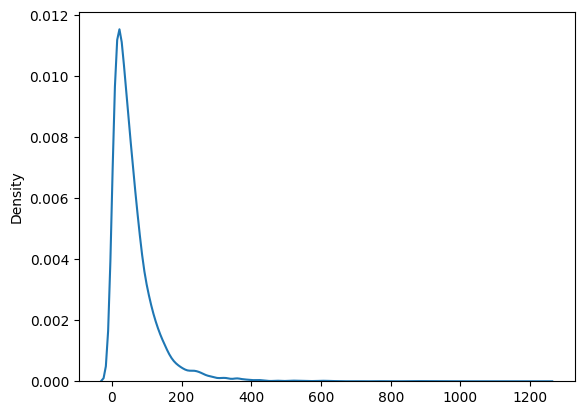

In [121]:
#### CONVERTING TEXT TO INDEXES AND TO SEQUENCES ####
# convert indexes to sequences
train['Description'] = train['Description'].astype(str) # astype of column to string 
seq = tokenizer.texts_to_sequences(train['Description'])
# length of each sentence in 'description' column
length_dist = [len(seq_i) for seq_i in seq]
sns.kdeplot(length_dist) # most of them center around 200-400, lets set maxlen to 200
# padding sequences
padded_train_eval = pad_sequences(seq, maxlen = 200,truncating='post', padding='post')

In [122]:
##### ONE-HOT CODING, EXTRACTING LABEL FROM ORIGINAL NON-TEXT DATA #####
train_eval = get_input(train,breed,color,state)[0] # use get_input function previously defined
# get label data
y_list = ['AdoptionSpeed_First_day', 'AdoptionSpeed_First_week', 'AdoptionSpeed_First_month', 'AdoptionSpeed_First_30_to_90_days', 'AdoptionSpeed_First_100_days']
label_train_eval = train_eval[y_list]
# drop y_column to get input data
data_train_eval = train_eval.drop(y_list,axis=1)

In [123]:
##### CONCATINATING TEXT AND NON TEXT DATA #####
full_concated_data = np.concatenate((data_train_eval, padded_train_eval), axis=1)

In [124]:
##### SPLITING INTO TRAIN-EVALUATION DATA SET #####
n_split = math.floor(full_concated_data.shape[0] * 0.8)
# Split data
data_train = full_concated_data[:n_split,:]
data_eval = full_concated_data[n_split:,:]
# Split label
label_train = label_train_eval.iloc[:n_split,:].values
label_eval = label_train_eval.iloc[n_split:,:].values
# Printing shape of these data sets
print(
    data_train.shape,
    label_train.shape,
    data_eval.shape,
    label_eval.shape
)

(11994, 567) (11994, 5) (2999, 567) (2999, 5)


## 3.3 Model building and evaluating

In [125]:
# Function that get model
def get_model(input_data, text_dimension):
    total_dimension = input_data.shape[1]
    textinput_dimension = text_dimension
    # Spliting input numerical and text data
    input_layer = Input(shape=(total_dimension,))
    numin, textin = tf.split(input_layer, num_or_size_splits=[total_dimension - textinput_dimension, textinput_dimension], axis=1)
    # Model for numerical data
    Dense1 = Dense(200)(numin)
    Dense2 = Dense(150)(Dense1)
    Dense3 = Dense(100)(Dense2)
    Dense4 = Dense(50)(Dense3)
    # Model for text data
    em = Embedding(max_word_index + 1, 100, input_length = textinput_dimension)(textin) # Current dimension = max_word_index + 1
    lstm = LSTM(textinput_dimension)(em) 
    Dense5 = Dense(50)(lstm)
    Dense6 = Dense(20)(Dense5)
    # Concatenate value from two previous paths
    merged = Concatenate()([Dense4, Dense6])
    # Last layer would be softmax
    output = Dense(5, activation='softmax')(merged)
    # Generate model
    model = Model(inputs=input_layer, outputs=output)
    # Compiling model
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    # Createing a checkpoint path to automatically save model
    checkpoint_path = os.path.join(os.getcwd(), "num_text_models\cp.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True
                                                    )
    return model, cp_callback

In [126]:
model, cp_callback = get_model(data_train, 200)

In [132]:
model.fit(
    x= data_train, 
    y= label_train, 
    epochs= 10, 
    batch_size = 2**9, 
    validation_data = (data_eval,label_eval),
    callbacks= [cp_callback]
    )

Epoch 1/10
24/24 [==============================] - 0s 10ms/step - loss: 0.6372 - recall: 0.7074 - val_loss: 0.6477 - val_recall: 0.6818
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.6351 - recall: 0.6773 - val_loss: 0.6489 - val_recall: 0.6584
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 0.6347 - recall: 0.6620 - val_loss: 0.6488 - val_recall: 0.6474
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.6347 - recall: 0.6543 - val_loss: 0.6497 - val_recall: 0.6591
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 0.6346 - recall: 0.6665 - val_loss: 0.6501 - val_recall: 0.6578
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 0.6346 - recall: 0.6512 - val_loss: 0.6496 - val_recall: 0.6532
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 0.6346 - recall: 0.6610 - val_loss: 0.6498 - val_recall: 0.6442
Epoch 8/10
24/24 [=============================

# Try changing target variable format

In [128]:
train['AdoptionSpeed'] = train['AdoptionSpeed'].astype(int).apply(lambda x: 
                                                1 if x <= 2
                                                else 0
                                                ) # 1 =  Fast (<1 moth), 0 = Slow (>=1 month)

In [129]:
########  DEFINING A FUNCTION THAT PREPARE CORRECT INPUT FOR MODEL #########
def get_input_new(df, breed,color,state):
    # Merging with other tables to get labels
    df_drop = df.drop(['PhotoAmt','PetID','Description','VideoAmt','RescuerID','Name'],axis=1)
    df_drop = df_drop.rename(columns={'Breed1':'BreedID'}).merge(breed, on=['BreedID','Type'],how='left').drop('BreedID',axis=1)
    df_drop = df_drop.rename(columns={'Breed2':'BreedID'}).merge(breed, on=['BreedID','Type'],how='left').drop('BreedID',axis=1)
    
    for color_col in ['Color1','Color2','Color3']:
        df_drop = df_drop.rename(columns={color_col: 'ColorID'}).merge(color, on ='ColorID', how = 'left').drop('ColorID',axis=1)
    df_drop = df_drop.rename(columns={'State':'StateID'}).merge(state,on ='StateID', how = 'left').drop('StateID',axis=1)

    # Get label of data to understand the context
    label_dict = {
        'Type': ['Not specified','Dog','Cat'],
        'Gender': ['Not specified','Male','Female','Mixed'],
        'FurLength': ['Not specified','Short','Medium','Long'],
        'Vaccinated': ['Not specified','Yes','No'],
        'Dewormed': ['Not specified','Yes','No'],
        'Sterilized': ['Not specified','Yes','No'],
        'Health': ['Not specified','Healthy','Minor Injury','Serious Injury'],
        'MaturitySize': ['Not specified','Small','Medium','Large','Extra Large']
    }

    for col in df_drop.columns:
        if col in label_dict:
            label_list = label_dict[col]
            for number in range(len(label_list)):
                df_drop[col][df_drop[col] == number] = label_list[number]
    df_labeled = df_drop
    df_dummy = pd.get_dummies(df_labeled,dtype=int)
    
    return df_dummy, df_labeled

### Neural network

In [130]:
# get desired input
data_train_eval = get_input_new(train, breed, color, state)[0] # take df_dum
label_train_eval = data_train_eval[['AdoptionSpeed']]
data_train_eval = data_train_eval.drop('AdoptionSpeed', axis = 1)

# Split train data to train - evaluate set:
n_split = math.floor(data_train_eval.shape[0] * 0.8)

data_train = data_train_eval.iloc[:n_split,:]
data_eval = data_train_eval.iloc[n_split:,:]

label_train = label_train_eval.iloc[:n_split,:]
label_eval = label_train_eval.iloc[n_split:,:]

# print out shape
print(
    data_train.shape,
    label_train.shape,
    data_eval.shape,
    label_eval.shape 
)

(11994, 367) (11994, 1) (2999, 367) (2999, 1)


In [131]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(data_train.shape[1],)),
    tf.keras.layers.Dense(units=200),
    tf.keras.layers.Dense(units=150),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=50),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.compile(
    loss= 'BinaryCrossentropy',
    optimizer= 'Adam',
    metrics = ['Recall']
)

model.fit(
    data_train,
    label_train,
    epochs = 100,
    validation_data=(data_eval, label_eval)
)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.8392 - recall: 0.6405 - val_loss: 0.6653 - val_recall: 0.5552
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6918 - recall: 0.6392 - val_loss: 0.6872 - val_recall: 0.7078
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6711 - recall: 0.6308 - val_loss: 0.6651 - val_recall: 0.7558
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6795 - recall: 0.6627 - val_loss: 0.6759 - val_recall: 0.5058
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6554 - recall: 0.6455 - val_loss: 0.6719 - val_recall: 0.7799
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6772 - recall: 0.6490 - val_loss: 0.6537 - val_recall: 0.6026
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 0.6680 - recall: 0.6695 - val_loss: 0.6518 - val_recall: 0.6552
Epoch 8/100
375/375 [======

KeyboardInterrupt: 

In [ ]:
def labeling_evaluating(y_true, y_pred, threshold):
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # visualizing confusion matrix:
    sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')

    # calcualte metric dict 
    metric_dict = calculate_perform_metrics(cm)
    print(metric_dict)

In [ ]:
labeling_evaluating(label_eval, 
                    model.predict(data_eval), 
                    threshold = 0.5)

### Neural network and RNN

In [ ]:
#### TOKENIZING ON TEXT DATA ####
# tokenize base on 'description' column in train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Description'].astype(str))
# get word index
word_index = tokenizer.word_index
max_word_index = max(word_index.values()) # 21808

#### CONVERTING TEXT TO INDEXES AND TO SEQUENCES ####
# convert indexes to sequences
train['Description'] = train['Description'].astype(str) # astype of column to string 
seq = tokenizer.texts_to_sequences(train['Description'])
# length of each sentence in 'description' column
length_dist = [len(seq_i) for seq_i in seq]
sns.kdeplot(length_dist) # most of them center around 200-400, lets set maxlen to 200
# padding sequences
padded_train_eval = pad_sequences(seq, maxlen = 200,truncating='post', padding='post')

In [ ]:
# get desired input
data_train_eval = get_input_new(train, breed, color, state)[0] # take df_dum
label_train_eval = data_train_eval[['AdoptionSpeed']]
data_train_eval = data_train_eval.drop('AdoptionSpeed', axis = 1)

In [ ]:
##### CONCATINATING TEXT AND NON TEXT DATA #####
full_concated_data = np.concatenate((data_train_eval, padded_train_eval), axis=1)

In [ ]:
##### SPLITING INTO TRAIN-EVALUATION DATA SET #####
n_split = math.floor(full_concated_data.shape[0] * 0.8)
# Split data
data_train = full_concated_data[:n_split,:]
data_eval = full_concated_data[n_split:,:]
# Split label
label_train = label_train_eval.iloc[:n_split,:].values
label_eval = label_train_eval.iloc[n_split:,:].values
# Printing shape of these data sets
print(
    data_train.shape,
    label_train.shape,
    data_eval.shape,
    label_eval.shape
)

In [ ]:
# Function that get model
def get_model(input_data, text_dimension):
    total_dimension = input_data.shape[1]
    textinput_dimension = text_dimension
    # Spliting input numerical and text data
    input_layer = Input(shape=(total_dimension,))
    numin, textin = tf.split(input_layer, num_or_size_splits=[total_dimension - textinput_dimension, textinput_dimension], axis=1)
    # Model for numerical data
    Dense1 = Dense(200)(numin)
    Dense2 = Dense(150)(Dense1)
    Dense3 = Dense(100)(Dense2)
    Dense4 = Dense(50)(Dense3)
    # Model for text data
    em = Embedding(max_word_index + 1, 100, input_length = textinput_dimension)(textin) # Current dimension = max_word_index + 1
    lstm = LSTM(textinput_dimension)(em) 
    Dense5 = Dense(50)(lstm)
    Dense6 = Dense(20)(Dense5)
    # Concatenate value from two previous paths
    merged = Concatenate()([Dense4, Dense6])
    # Last layer would be softmax
    output = Dense(1, activation='sigmoid')(merged)
    # Generate model
    model = Model(inputs=input_layer, outputs=output)
    # Compiling model
    model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['F1Score'])
    # Createing a checkpoint path to automatically save model
    checkpoint_path = os.path.join(os.getcwd(), "num_text_models_new\cp.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True
                                                    )
    return model, cp_callback

In [ ]:
data_train = data_train.astype('float32')
label_train = label_train.astype('float32')
data_eval = data_eval.astype('float32')
label_eval = label_eval.astype('float32')

In [ ]:
model, cp_callback = get_model(data_train, 200)

hist = model.fit(
    x= data_train, 
    y= label_train, 
    epochs= 10, 
    batch_size = 2**9, 
    validation_data = (data_eval,label_eval),
    callbacks= [cp_callback]
    )

In [ ]:
labeling_evaluating(
    label_eval, 
    model.predict(data_eval), 
    threshold = 0.5
)

# Final Conclusion

### **Result Summary:**

- Neural Network on Non-Text Data: Achieved an accuracy of approximately 0.5.
- Neural Network Combined with RNN on Both Text and Non-Text Data: Attained an accuracy of around 0.3.
- Reformatted Target, Neural Network on Non-Text Data: Demonstrated an accuracy of roughly 0.65.
- Reformatted Target, Neural Network Combined with RNN on Both Text and Non-Text Data: Showed an accuracy of about 0.6.

### **Conclusion:**

It appears that, with the current approach, predicting the adoption speed for pets is a challenging task.

The textual descriptions of the pets do not appear to contribute positively to the model's performance; in fact, they seem to have a detrimental effect.

Reformatting the target variable to transform this into a two-label classification problem has led to a slight improvement in the model's performance.

However, given the current accuracy and other metrics, it is evident that the model requires substantial improvements and changes to be effective.